# [GLIDE](https://arxiv.org/abs/2112.10741)
## 텍스트 기반 확산 모델을 사용한 사실적 이미지 생성 및 편집
이 노트북은 GLIDE + 필터링된 노이즈 인식 CLIP 모델을 사용하여 텍스트 프롬프트에 따라 이미지를 생성하는 방법을 보여줍니다.



In [1]:
#@title Clone and install
%%capture
# `%%capture`는 Jupyter notebook이나 Google Colab에서 cell의 출력을 숨기는 명령어입니다.

# GLIDE (OpenAI의 Text2Image 프로젝트) 저장소를 복제(clone)
!git clone https://github.com/openai/glide-text2im.git

# 복제한 저장소의 디렉토리로 이동
%cd /content/glide-text2im/

!pip install -e .  # 현재 디렉토리의 소스 코드를 기반으로 패키지를 편집 가능 모드로 설치
!pip install ftfy  # 'ftfy'는 텍스트를 깔끔하게 정리하는 라이브러리

In [2]:
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn

from glide_text2im.clip.model_creation import create_clip_model   # CLIP 모델 생성 함수
from glide_text2im.download import load_checkpoint

from glide_text2im.model_creation import (
    create_model_and_diffusion,        # 디퓨전과 함께 모델을 생성하는 함수
    model_and_diffusion_defaults,      # 모델과 디퓨전에 대한 기본 설정 제공 함수
    model_and_diffusion_defaults_upsampler,  # 업샘플러에 대한 모델과 디퓨전의 기본 설정 제공 함수
)

from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

In [3]:
# gpu 유무 check
has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
device

device(type='cuda')

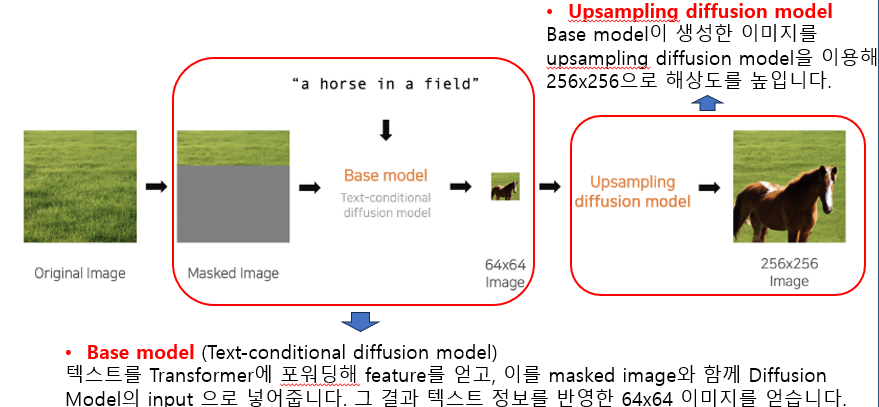

In [5]:
#@title base 및 upsampler 모델 생성
# base model 생성
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda   # gpu가 있으면 16비트 부동 소수점 숫자 형식 사용
options['timestep_respacing'] = '100'   # 빠른 샘플링을 위해 100개의 확산 단계 사용
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('base model의 총 parameter 수 {:,}'.format(sum(x.numel() for x in model.parameters())))

# upsampler model 생성
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # 매우 빠른 샘플링을 위해 27개의 확산 단계 사용.
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('upsampler 모델의 총 parameter 수 {:,}'.format(sum(x.numel() for x in model_up.parameters())))

base model의 총 parameter 수 385,030,726
upsampler 모델의 총 parameter 수 398,361,286


In [6]:
#@title CLIP 모델 생성
clip_model = create_clip_model(device=device)
clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))

  0%|          | 0.00/346M [00:00<?, ?iB/s]

  0%|          | 0.00/287M [00:00<?, ?iB/s]

<All keys matched successfully>

In [7]:
def show_images(batch: torch.Tensor):
    """ Display a batch of images inline. """
    # 이미지의 픽셀 값을 [0, 255] 범위로 조정하여 화면에 표시하기 적절한 형태로 변환
    scaled = ((batch + 1)*127.5).round().clamp(0, 255).to(torch.uint8).cpu()

    # 여러 이미지를 하나의 이미지로 연결합니다.
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])

    # Tensor를 numpy 배열로 변환하여 PIL 이미지로 만듭니다.
    img = Image.fromarray(reshaped.numpy())

    # 생성된 이미지 저장
    img.save("/content/glide_out.png", format="png")

    display(img)

In [10]:
#@title 샘플링 매개변수 설정
# 사용자로부터 입력을 받아 'prompt' 변수에 저장.  이미지 생성에 사용될 텍스트 설명.
prompt = "A castle with advocado shape"
# 배치 크기 설정 - 기본 모델에서 생성할 이미지 갯수
batch_size =  8
# 가이던스 스케일은 이미지 생성에 있어 텍스트 설명의 영향력을 조절 (0 - 영향무)
guidance_scale = 3.0
# 업샘플링 온도는 이미지의 세부적인 특징을 조절하는 데 사용 (0~1)
upsample_temp = 0.997

### 기본 모델에서 작은 이미지를 샘플링

In [12]:
# 텍스트 프롬프트를 토큰화합니다. 이 토큰들은 모델의 입력으로 사용됩니다.
tokens = model.tokenizer.encode(prompt)

# 토큰을 지정된 컨텍스트 길이에 맞게 패딩하고, 패딩 마스크를 생성합니다.
# 마스크는 패딩된 부분을 모델이 무시하도록 도와줍니다.
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

print(len(tokens))
print(tokens)
print(mask)

128
[64, 16669, 351, 5271, 4533, 5485, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
[True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, 

기본 모델에서 sampling한 토큰을 생성할 image 갯수만큼 복제하여 batch로 만들어 줍니다.

In [17]:
# 모델에 입력할 파라미터들을 담고 있는 딕셔너리를 생성
model_kwargs = dict(
    # 텍스트 토큰을 PyTorch 텐서로 변환하고, 배치 사이즈만큼 복제
    tokens=torch.tensor([tokens] * batch_size, device=device),
    # 패딩 마스크를 PyTorch 텐서로 변환하고, 배치 사이즈만큼 복제
    mask=torch.tensor([mask] * batch_size, dtype=torch.bool, device=device),
)

model_kwargs

{'tokens': tensor([[   64, 16669,   351,  ..., 50256, 50256, 50256],
         [   64, 16669,   351,  ..., 50256, 50256, 50256],
         [   64, 16669,   351,  ..., 50256, 50256, 50256],
         ...,
         [   64, 16669,   351,  ..., 50256, 50256, 50256],
         [   64, 16669,   351,  ..., 50256, 50256, 50256],
         [   64, 16669,   351,  ..., 50256, 50256, 50256]], device='cuda:0'),
 'mask': tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]], device='cuda:0')}

### CLIP 모델을 gudie 함수로 설정

In [18]:
# 이미지 생성 과정에서 CLIP 모델을 사용하여 생성된 이미지가
# 텍스트 프롬프트와 얼마나 잘 일치하는지 평가하고,
# 그 평가 결과를 바탕으로 이미지 생성을 가이드하는 함수(cond_fn) 설정
cond_fn = clip_model.cond_fn([prompt] * batch_size, guidance_scale)

batch로 packaging한 토큰을 이용하여 64x64 크기의 image 생성

  0%|          | 0/100 [00:00<?, ?it/s]

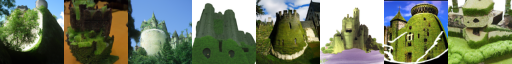

In [19]:
# 베이스 모델로부터 샘플링

# 이전에 사용된 메모리를 정리하여 새로운 샘플링을 위한 공간 확보
model.del_cache()

# Diffusion 과정을 사용하여 베이스 모델로부터 이미지를 샘플링
samples = diffusion.p_sample_loop(
    model,                             # 이미지 생성에 사용할 base 모델
    (batch_size, 3, options["image_size"], options["image_size"]),  # 생성할 이미지의 배치 크기와 사이즈
    device=device,
    clip_denoised=True,        # 디노이징을 적용할지 여부
    progress=True,                # 샘플링 진행 상황을 표시할지 여부
    model_kwargs=model_kwargs,        # 위에서 생성한 매개변수 딕셔너리
    cond_fn=cond_fn,           # 이미지 생성에 특정 조건을 적용하기 위한 가이드 함수
)

# 샘플링이 끝난 후 다시 모델의 캐시를 삭제하여 메모리 해제
model.del_cache()

# 생성된 작은 이미지 샘플들을 시각화
show_images(samples)

In [20]:
samples.shape

torch.Size([8, 3, 64, 64])

64x64 이미지를 256x256 이미지로 Upsampling

  0%|          | 0/27 [00:00<?, ?it/s]

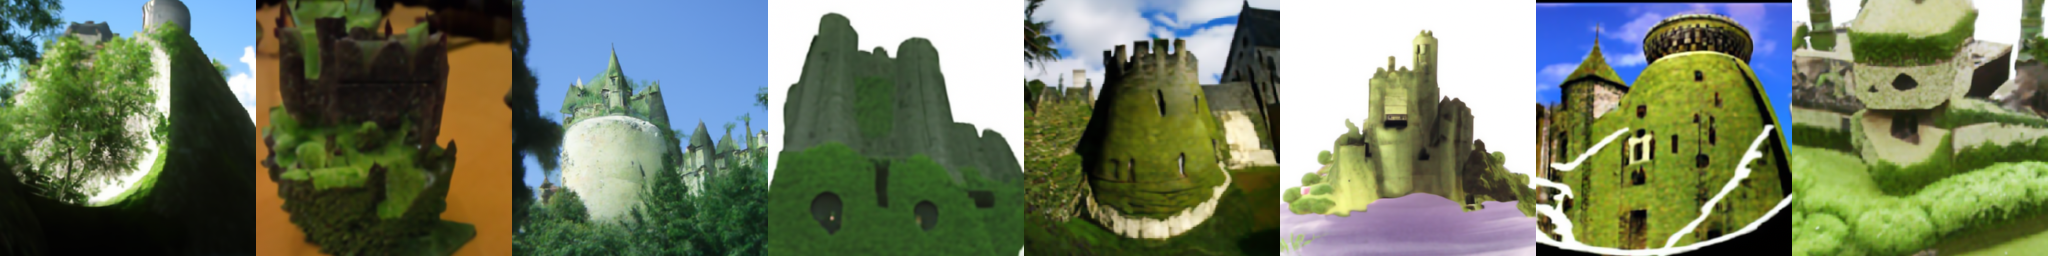

In [21]:
# upsampler model을 위해 텍스트 프롬프트를 토큰화하고, 패딩과 마스크 생성
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# 입력 설정을 위한 딕셔너리 생성
model_kwargs = dict(
    # 저해상도 이미지를 (-1, 1) 사이로 스케일링
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # 텍스트 토큰을 PyTorch 텐서로 변환하고, 배치 사이즈만큼 복제
    tokens=torch.tensor([tokens] * batch_size, device=device),
    # 패딩 마스크를 PyTorch 텐서로 변환하고, 배치 사이즈만큼 복제
    mask=torch.tensor([mask] * batch_size, dtype=torch.bool, device=device),
)

# upsampler model의 캐시 초기화
model_up.del_cache()

# 업샘플링 모델을 사용하여 저해상도 이미지를 고해상도로 업샘플
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])

up_samples = diffusion_up.ddim_sample_loop(
    model_up,                # 업샘플링을 수행할 모델
    up_shape,                # 업샘플링된 이미지의 형태
    noise=torch.randn(up_shape, device=device) * upsample_temp,  # 노이즈와 온도 설정을 통해 이미지의 세부적 특징 조절
    device=device,
    clip_denoised=True,  # 디노이징 옵션
    progress=True,          # 진행 상황 표시 여부
    model_kwargs=model_kwargs,    # 위에서 생성한 매개변수 딕셔너리
    cond_fn=None,         # 조건부 함수 사용 않음
)[:batch_size]

# 업샘플링이 완료되면 모델의 캐시를 다시 초기화
model_up.del_cache()

# 업샘플링된 이미지 시각화
show_images(up_samples)

In [22]:
up_samples.shape

torch.Size([8, 3, 256, 256])

In [23]:
#@title Download (Optional)
from google.colab import files
files.download('/content/glide_out.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>